In [1]:
from phi.flow import *

In [4]:
OBSTACLE_X = tensor([15, 30, 50], batch('obstacle_pos'))
OBSTACLE = Box(x=(OBSTACLE_X - 15, OBSTACLE_X + 15), y=(50, 52))

In [6]:
def step(v, s, p, dt=1.):
    s = advect.mac_cormack(s, v, dt) + INFLOW
    buoyancy = s * (0, 0.1) @ v  # resamples smoke to velocity sample points
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, [OBSTACLE], Solve('auto', 1e-5, 0, x0=p))
    return v, s, p

velocity = StaggeredGrid((0, 0), 0, x=64, y=64, bounds=Box(x=100, y=100))
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=200, y=200, bounds=Box(x=100, y=100))
INFLOW = 0.2 * resample(Sphere(x=50, y=9.5, radius=5), smoke, soft=True)
pressure = None

for _ in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure)

<Figure size 1200x500 with 3 Axes>

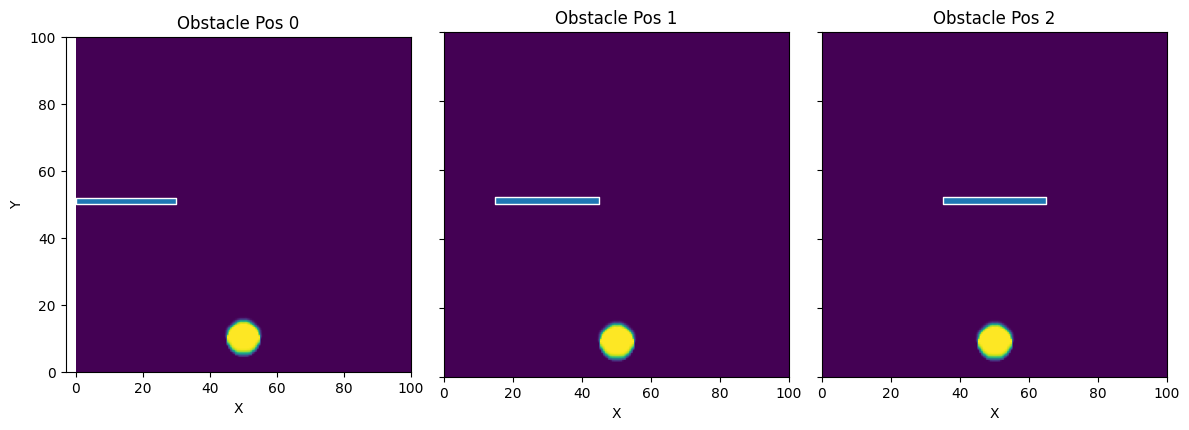

In [7]:
plot(vis.overlay(smoke, OBSTACLE), show_color_bar=False)

<Figure size 1200x500 with 3 Axes>

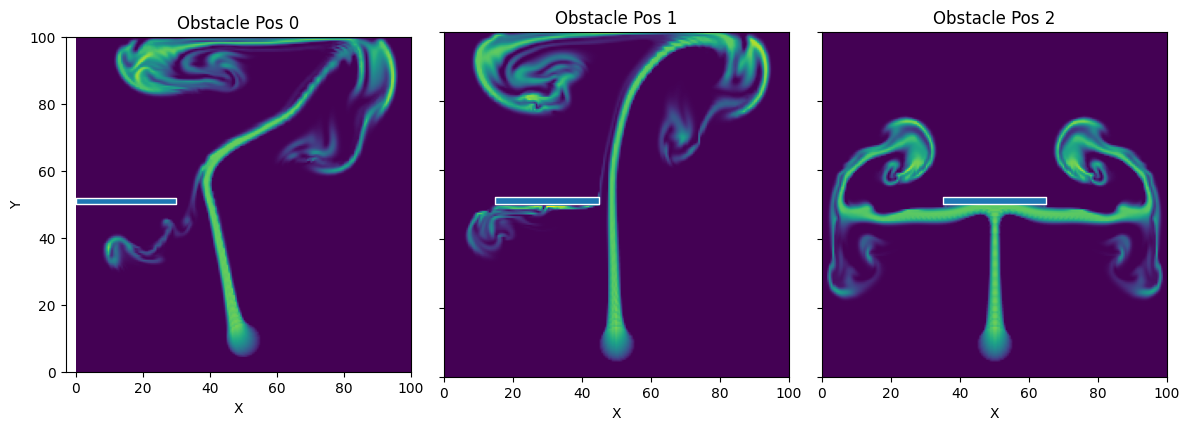

In [8]:
for _ in range(100):
    velocity, smoke, pressure = step(velocity, smoke, pressure)
plot(vis.overlay(smoke, OBSTACLE), show_color_bar=False)